## Intro

In [216]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad
import time

Useful function for the plot

In [217]:
def display_band(X, par, epsi=0.001, col="k"):
    print(par)
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght
    k = 0.01
    dx = x2 - x1
    dy = y2 - y1
    l = np.sqrt(dx**2 + dy**2)
    x1 = x1 - k * l
    x2 = x2 + k * l
    y1 = y1 - k * l
    y2 = y2 + k * l
    ##
    if np.abs(par[1]).all() < 2e-2:  # .all() added
        # disp('vertical line')
        a = np.vstack([-(par[1] * y1 + par[2]) / par[0], y1])
        b = np.vstack([-(par[1] * y2 + par[2]) / par[0], y2])
    else:
        a = np.vstack([x1, -(par[0] * x1 + par[2]) / par[1]])
        b = np.vstack([x2, -(par[0] * x2 + par[2]) / par[1]])

    if np.abs(par[0]) < 1e-5:
        v = np.array([0, 1])
    else:
        v = np.array([1, par[1] / par[0]])  # direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px, py, np.ones_like(px), colors=col, alpha=0.5)
    plt.gca().set_aspect("equal")

Function that computes the residual between points and a line

In [218]:
def res_line(X, M):
    if len(M.shape) > 1:
        num_lines = M.shape[1]
    else:
        num_lines = 1

    if num_lines == 1:
        d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
    else:
        n = X.shape[1]
        d = np.zeros((n, num_lines))
        for i in range(num_lines):
            d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])

    return d  # added

## OLS y DLT

Implement the following function, that computes the solution of the overdetermined system

$$\underset{A}{\text{argmin}} \| A\mathbf x - \mathbf y\|_2^2$$

via OLS and DLT

The input $P=[[x_1, y_1], \dots,[x_N,y_N]]$ collects the points where the line $y = mx+q$ should pass through


In [219]:
def fit_line_ols(P):
    # design matrix
    if P.ndim == 1:
        P = P[:, np.newaxis]
    ones_column = np.ones((P.shape[1], 1))
    A = np.concatenate((P.T, ones_column), axis=1)  # A = [[x1,y1,1],[x2,y2,1],...,[xn,yn,1]]
    X = A[:, [0, 2]]  # X = [[x1,1],[x2,1],...,[xn,1]]'

    # vector of responses
    y = A[:, 1]

    # straight line coefficient
    theta = 0
    try:
        theta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    except np.linalg.LinAlgError:
        # if can't invert matrix, use ridge regression
        alpha=1e-5
        I = np.eye(X.shape[1])
        theta = np.linalg.inv(X.T @ X + alpha * I) @ (X.T @ y)

        theta = np.linalg.pinv(X.T @ X) @ (X.T @ y)

    residuals = y - (X @ theta)
    residual_error = np.sum(residuals**2)
    return theta, residuals, residual_error

In [220]:
def fit_line_dlt(P):

    # Precondition = normalizing
    mx = np.mean(P[0, :])
    my = mx = np.mean(P[1, :])
    stdx = np.std(P[0, :])
    stdy = mx = np.std(P[1, :])

    # design matrix

    x_col = (P[0, :] - mx) / stdx
    y_col = (P[1, :] - my) / stdy
    ones_col = np.ones(P.shape[1])
    A = np.vstack((x_col, y_col, ones_col)).T  # A = [[x1,y1,1],[x2,y2,1],...,[xn,yn,1]]

    # vector of responses
    # y = P.T[:, 1]

    _, _, V = np.linalg.svd(A)

    theta = V.T[:, -1]

    # Invert precondition = denormalizing
    a = theta[0] / stdx
    b = theta[1] / stdy
    c = theta[2] - (((theta[0] * mx) / stdx) + ((theta[1] * my) / stdy))

    theta = np.array([a, b, c])

    residuals = A @ theta
    residual_error = np.sum(residuals**2)
    return theta, residuals, residual_error

Robust Fitting Methods
----------------------
Implements the following methods:

In [221]:
def simpleRANSAC(X, eps, cardmss=2):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    eps: threshold for the residuals                # on paper called: E
    cardmss: cardinality of the minimal sample set  # on paper called: s
    """
    # number of samples in the dataset
    n = X.shape[1]
    # Desired probability of success
    alpha = 0.99 # on paper called: p -> high probability

    # Pessimistic estimate of inliers fraction
    f = 0.5     # on paper called: e -> probability of having 1 outlier

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1 - (1-f)**cardmss))

    # set maximum consensus reached
    maxscore = 0

    for i in range(MaxIterations):

        # Generate cardmss random indices in the range 0..n-1 
        rand_choice = np.random.choice(n, cardmss, replace=False)
        mss = X[:, rand_choice]

        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]
        # samething, another method
        # inliers = np.where(np.abs(sqres) > eps, 0, 1) # 1 if inlier, 0 if outlier

        # assess consensus (the number of inliers)
        score = len(inliers)


        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            bestmodel = theta
            maxscore = score
            bestinliers = inliers

    return bestmodel, bestinliers

In [222]:
def simpleMSAC(X, eps, cardmss=2):

    n = X.shape[1]
    alpha = 0.99  # Desired probability of success
    f = 0.5  # Pessimistic estimate of inliers fraction

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1 - (1-f)**cardmss))

    # set maximum consensus reached
    mincost = np.inf

    for i in range(MaxIterations):
        
        # Generate cardmss random indices in the range 0..n-1
        rand_choice = np.random.choice(n, cardmss, replace=False)
        mss = X[:, rand_choice]

        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres <= eps)[0]

        # Compute MSAC score
        fr = np.where(sqres > eps, eps, sqres) # f(r) = {E if |r|>E; |r| if |r|<=E}
        cost = np.sum(fr)
        # cost = 0
        # if sqres > eps:
        #     cost += eps
        # else:
        #     cost += sqres

        # replace mincost, bestinliers and bestmodel if needed
        if cost < mincost:
            bestmodel = theta
            mincost = cost
            bestinliers = inliers

    return bestmodel, bestinliers

In [223]:
def simpleLMEDS(X, cardmss=2):
    n = X.shape[1]
    alpha = 0.99  # Desired probability of success
    f = 0.5  # Pessimistic estimate of inliers fraction

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1 - (1-f)**cardmss))

    # set maximum consensus reached
    mincost = np.inf

    for i in range(MaxIterations):
        # Generate cardmss random indicies in the range 0..n-1
        rand_choice = np.random.choice(n, cardmss, replace=False)
        mss = X[:, rand_choice]

        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # Compute LMS score
        cost = np.median(sqres)

        # define inliner threshold (does make sense only when the model provides a good fit)
        # compute the standard deviation of distances (you can use MAD)
        scale = mad(sqres)

        # instead of 3-sigma rule, we do 2.5-sigma rule. sqres is already squares
        inliers = np.where(sqres < 2.5 * scale)[0]

        # replace mincost, bestinliers and bestmodel if needed
        if cost < mincost:
            bestmodel = theta
            mincost = cost
            bestinliers = inliers

    return bestmodel, bestinliers

Fitting over noisy data
-----------------------
Set the parameters and generate the dataset

In [224]:
cardmss = 2  # minimum number of points required to fit a model

# plotting params
BAND_WIDTH = 0.05
BAND_COLOR = "b"

# create noisy dataset
x = np.linspace(0, 1, 100)
y = 1.5 * x + 1
X = np.vstack((x, y))
sigma = 0.01
X = X + sigma * np.random.normal(size=X.shape)

Least square fit to noisy data

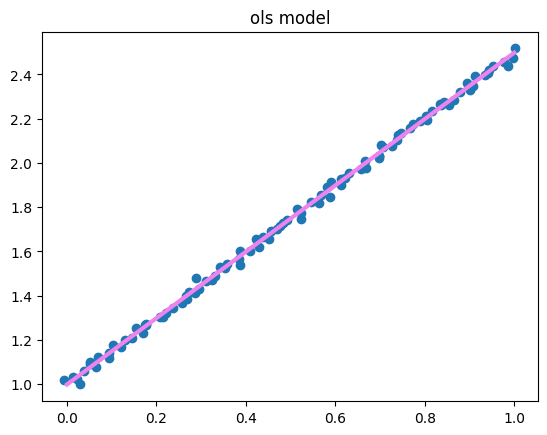

In [225]:
model_OLS = fit_line_ols(X)
plt.figure()
plt.scatter(X[0, :], X[1, :])
plt.plot(
    [0, 1], [model_OLS[0][1], model_OLS[0][0] + model_OLS[0][1]], "violet", linewidth=3
)
plt.title("ols model")
plt.show()

Least square fit via DLT (different model parametrization)

[ 2.3949541  -1.59597974  1.59307059]


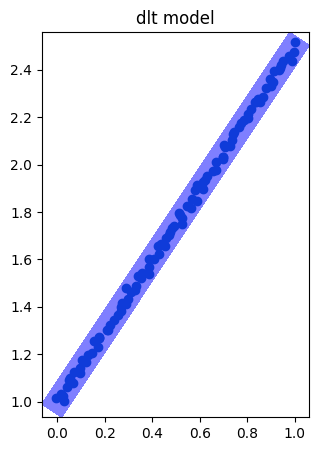

In [226]:
model_DLT = fit_line_dlt(X)
plt.figure(figsize=(15, 5))
plt.scatter(X[0, :], X[1, :])
display_band(X, model_DLT[0], BAND_WIDTH, BAND_COLOR)  # change second parameter from model_DLT to model_DLT[0] (because it should use theta only)
plt.title("dlt model")
plt.show()

Add a single outlier to the data, obtaining a new dataset $X_{out}$

In [227]:
outlier = np.array([[1.2], [3.0]])  # Adding an outlier point (x=1.2, y=3.0)
X_out = np.hstack((X, outlier))

Least square fit to noisy data with a single outlier

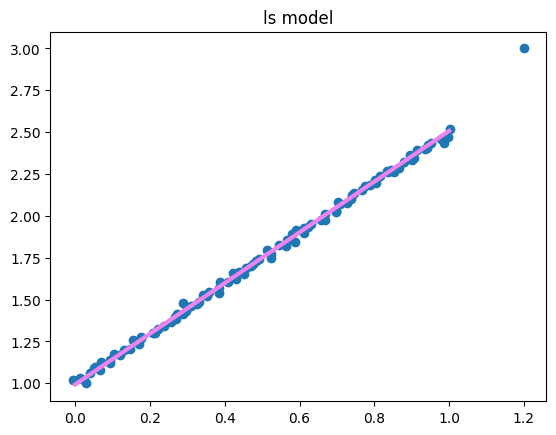

In [228]:
model_OLS = fit_line_ols(X_out)
plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
plt.plot([0, 1], [model_OLS[0][1], model_OLS[0][0] + model_OLS[0][1]], "violet", linewidth=3)
plt.title("ls model")
plt.show()

Least square fit via DLT to noisy data with a single outlier

[ 2.34857164 -1.54768399  1.53460741]


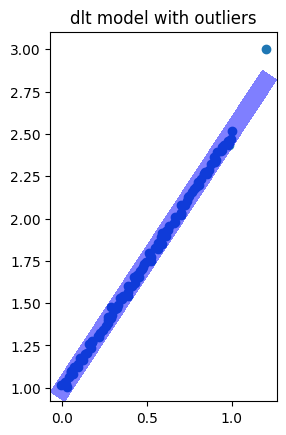

In [229]:
model_DLT = fit_line_dlt(X_out)
plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
display_band(X_out, model_DLT[0], BAND_WIDTH, BAND_COLOR)
plt.title("dlt model with outliers")
plt.show()

Add many outliers to the noisy data

In [230]:
n_out = 50

outliers_x = np.random.uniform(low=0, high=1, size=n_out)  # Outliers in x-range
outliers_y = np.random.uniform(low=0, high=4.0, size=n_out)  # Outliers in y-range
outliers = np.vstack((outliers_x, outliers_y))

# Add outliers to the dataset
X_out = np.hstack((X, outliers))

Least square fit

[1.29018312 1.24945178]


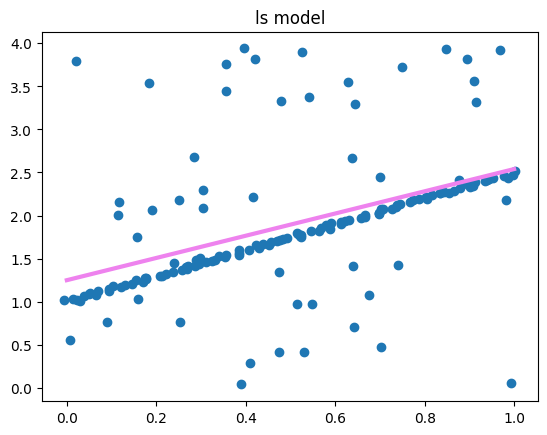

In [231]:
model_OLS = fit_line_ols(X_out)
print(model_OLS[0])
plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
plt.plot([0, 1], [model_OLS[0][1], model_OLS[0][0] + model_OLS[0][1]], "violet", linewidth=3)
plt.title("ls model")
plt.show()

Least square via DLT

[ 1.7975445  -0.36937026  0.0138012 ]


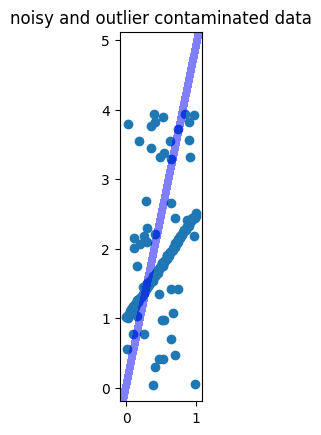

In [232]:
model_DLT = fit_line_dlt(X_out)
plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
display_band(X_out, model_DLT[0], BAND_WIDTH, BAND_COLOR)
plt.title("noisy and outlier contaminated data")
plt.show()

Robust Fitting methods
----------------------
Use Ransac, M-Sac and L-Meds to perform fitting on data with many outliers

Ransac:


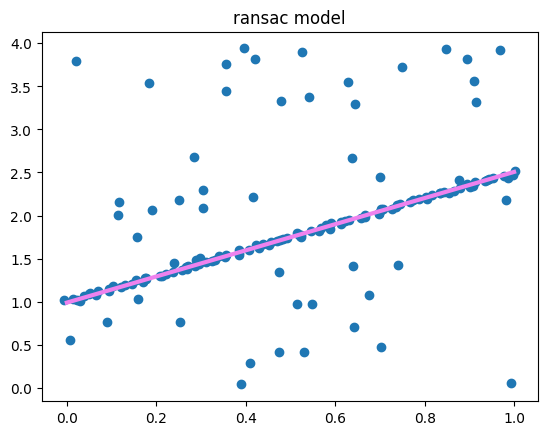

In [233]:
epsi = 3 * sigma  # define inlier threshold

# invoke simpleRANSAC
bestmodel, bestinliers = simpleRANSAC(X_out, epsi, cardmss)

# refine model estimates
# optimize bestmodel on its inliers via least squares refinement
refinedModel = fit_line_ols(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
# this plot works when model has 3 or more components
# display_band(X_out, refinedModel, epsi, BAND_COLOR) 
# in this case we have only 2, so we'll use the following line
plt.plot([0, 1], [refinedModel[1], refinedModel[0] + refinedModel[1]], "violet", linewidth=3) 
plt.title("ransac model")
plt.show()

M-Sac:

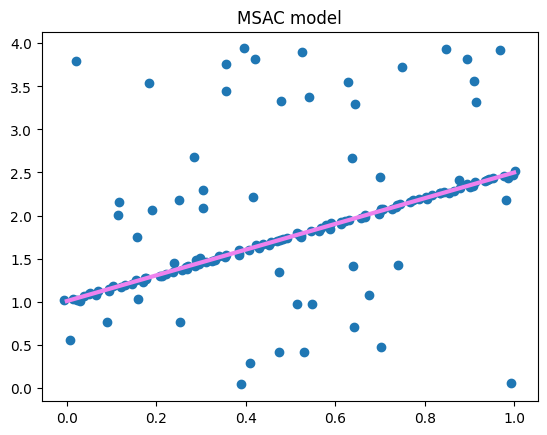

In [234]:
bestmodel, bestinliers = simpleMSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = fit_line_ols(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
# this plot works when model has 3 or more components
# display_band(X_out, refinedModel, epsi, BAND_COLOR) 
# in this case we have only 2, so we'll use the following line
plt.plot([0, 1], [refinedModel[1], refinedModel[0] + refinedModel[1]], "violet", linewidth=3) 
plt.title("MSAC model")
plt.show()

L-Meds:

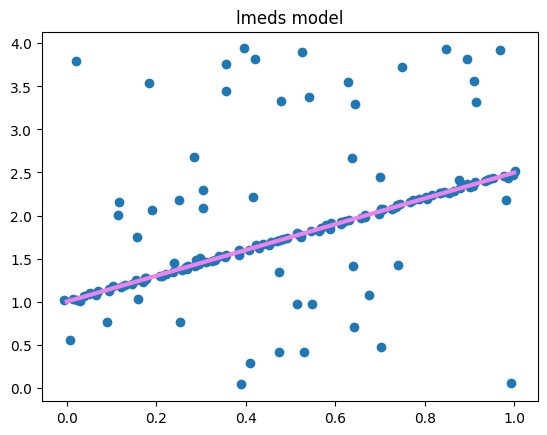

In [235]:
# invoke simpleLMEDS
bestmodel, bestinliers = simpleLMEDS(X_out, cardmss)

# refine model estimates
refinedModel = fit_line_ols(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0, :], X_out[1, :])
# this plot works when model has 3 or more components
# display_band(X_out, refinedModel, epsi, BAND_COLOR) 
# in this case we have only 2, so we'll use the following line
plt.plot([0, 1], [refinedModel[1], refinedModel[0] + refinedModel[1]], "violet", linewidth=3)
plt.title("lmeds model")
plt.show()